### read in center driving images created from full track both clockwise & counter-clockwise

In [7]:
import csv

DATADIRECTORY="./simData"

IMAGEDIRECTORY="./simData/track/IMG"
DRIVINGLOG=DATADIRECTORY+"/track/driving_log.csv"
lines=[]
with open(DRIVINGLOG) as csvFile:
    reader=csv.reader(csvFile)
    for line in reader:
        lines.append(line)
print("lines:", len(lines))

import cv2

CENTERIMAGE=0
STEERINGMEASUEMENT=3
CAMERAS=3
# CENTER, LEFT, RIGHT
STERRINGADJUSTMENT=[0, .25, -.25]

FLIPIMAGES=True

if FLIPIMAGES:
    BATCHSIZE=32 #flipped images
else:
    BATCHSIZE=64

IMAGECROP=((50,20), (0,0))

lines: 10837


### create a generator to feed images, flip center driving images & adjust steering angle to augment images set

In [3]:
import cv2
import numpy as np
import sklearn


if FLIPIMAGES:
    AUGMENTEDIMAGESBY=6 # add flipped images
else:
    AUGMENTEDIMAGESBY=3


def readImage(imagePathOnRemote):
    filename=imagePathOnRemote.split("/")[-1]
    imagePath=IMAGEDIRECTORY+"/"+filename
    image=cv2.imread(imagePath)
    #print("imagePath:", imagePath, "image.shape:", image.shape)
    return image;

def generator(lines, batchSize=128, shuffleData=True):
    #print("lines:", len(lines))
    numberOfSamples = len(lines)
    while 1: # Loop forever so the generator never terminates
        if shuffleData:
            lines=sklearn.utils.shuffle(lines) # every epoch
        #print("shuffled lines:", len(lines))
        for offset in range(0, numberOfSamples, batchSize):
            batchOfLines = lines[offset:offset+batchSize]

            images=[]
            steeringMeasurements=[]

            for line in batchOfLines:
                for camera in range(CAMERAS):
                    imagePathOnRemote=line[camera]
                    image=readImage(imagePathOnRemote)
                    if (image is None):
                        print ("line:", line)
                        print("image:", image, ", imagePathOnRemote:", imagePathOnRemote)
                        exit
                    images.append(image)
                    steering=float(line[STEERINGMEASUEMENT])+STERRINGADJUSTMENT[camera]
                    steeringMeasurements.append(steering)
                    if FLIPIMAGES:
                        images.append(cv2.flip(image,1))
                        steeringMeasurements.append(steering*-1)
                    assert len(images)==len(steeringMeasurements)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(steeringMeasurements)
            assert len(X_train)==len(y_train)
            #print("X_train.shape:", X_train.shape, "y_train.shape:", y_train.shape)
            #print("X_train[0].shape:", X_train[0].shape)
            if shuffleData:
                X_train, y_train=sklearn.utils.shuffle(X_train, y_train)
            yield X_train, y_train

### split image set into training set & validation set

In [4]:
from sklearn.model_selection import train_test_split

train_samples, validation_samples = train_test_split(lines, test_size=0.2)
print("train_samples:", len(train_samples), "validation_samples:", len(validation_samples))
print("train_samples[0]:",len(train_samples[0]))

# compile and train the model using the generator function
train_generator = generator(train_samples, batchSize=BATCHSIZE)
validation_generator = generator(validation_samples, batchSize=BATCHSIZE)

observe_train_generator = generator(train_samples, batchSize=BATCHSIZE, shuffleData=False)
firstTrainingBatch, firstSteeringBatch=next(observe_train_generator)
print("train_generator:", len(firstTrainingBatch))
print("firstTrainingBatch.shape:",firstTrainingBatch.shape, ", firstSteeringBatch.shape:", firstSteeringBatch.shape)
assert len(firstTrainingBatch) == len(firstSteeringBatch)
assert len(firstTrainingBatch) == AUGMENTEDIMAGESBY*BATCHSIZE

train_samples: 8669 validation_samples: 2168
train_samples[0]: 7
train_generator: 192
firstTrainingBatch.shape: (192, 160, 320, 3) , firstSteeringBatch.shape: (192,)


### show sample images with cropping

images.shape: (192, 160, 320, 3) , steeringAngles.shape: (192,)
augmentedImageBatchSize: 6 , augmentedImageBatches: 32
randomAugmentedImageBatchIndicies: [12, 30, 7] sizeOnScreen: (80.0, 160.0)


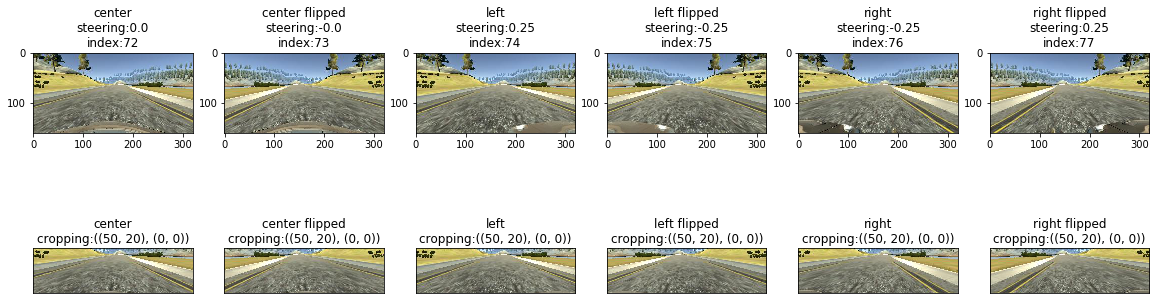

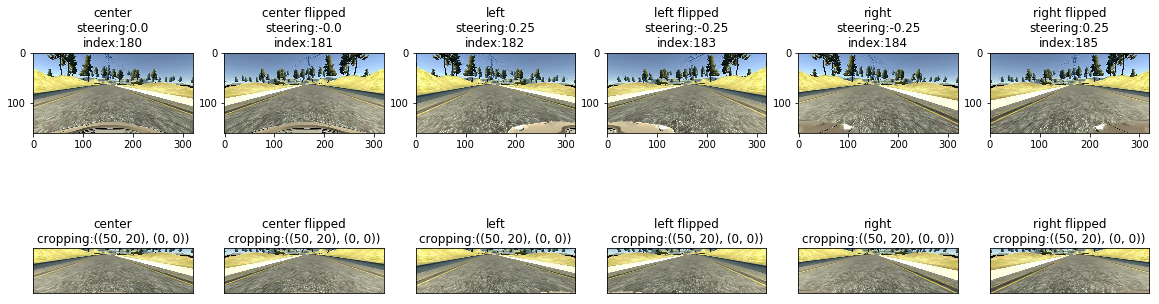

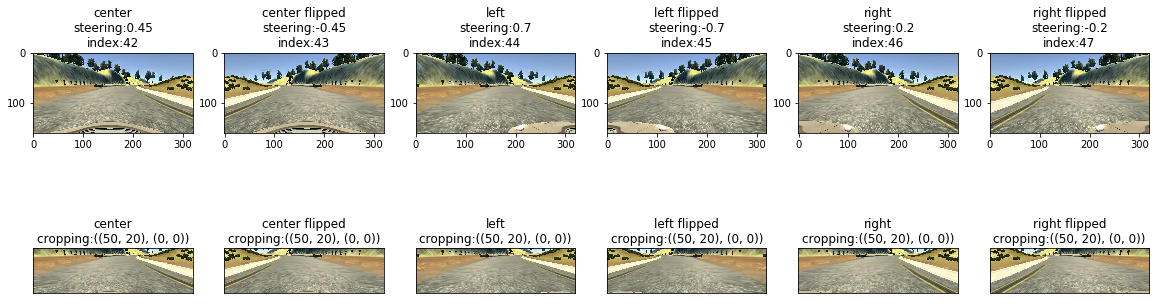

In [4]:
import matplotlib.pyplot as plt
import random

%matplotlib inline

if FLIPIMAGES:
    imageNames=["center", "center flipped", "left", "left flipped","right", "right flipped"]
else:
    imageNames=["center", "left", "right"]
    
NUMBEROFSAMPLESTOSHOW=3

def plot_images(images, steeringAngles, imageNames):
    print("images.shape:",images.shape, ", steeringAngles.shape:", steeringAngles.shape)
    assert len(images) == len(steeringAngles)
    imageShape = (images.shape[1], images.shape[2])
    augmentedImageBatchSize=len(imageNames)
    augmentedImageBatches = int(len(images)/augmentedImageBatchSize)
    print("augmentedImageBatchSize:",augmentedImageBatchSize, ", augmentedImageBatches:", augmentedImageBatches)
   
    randomAugmentedImageBatchIndicies=random.sample(range(0,augmentedImageBatches), NUMBEROFSAMPLESTOSHOW)
    #randomAugmentedImageBatchIndicies=(0,1,2)
    sizeOnScreen=(images[0].shape[0]/2, images[0].shape[1]/2)
    print ("randomAugmentedImageBatchIndicies:",randomAugmentedImageBatchIndicies, "sizeOnScreen:", sizeOnScreen)
    for augmentedBatchIndex in range(len(randomAugmentedImageBatchIndicies)):
    #for augmentedBatchIndex in range(0,1):
        randomAugmentedBatchIndex=randomAugmentedImageBatchIndicies[augmentedBatchIndex]
        beginningListIndexForBatch=augmentedImageBatchSize*randomAugmentedBatchIndex
        #print("augmentedBatchIndex:", augmentedBatchIndex,", randomAugmentedImageBatchIndicies:", randomAugmentedImageBatchIndicies, ", beginningListIndexForBatch:", beginningListIndexForBatch)
        #print("beginningListIndexForBatch:", beginningListIndexForBatch, "from batch:", randomAugmentedBatchIndex)
        if FLIPIMAGES:
            batchFigure=plt.figure(augmentedBatchIndex+1, figsize=(20,12))
        else:
            batchFigure=plt.figure(augmentedBatchIndex+1, figsize=(20,15))
        #batchFigure=plt.figure(augmentedBatchIndex+1)
        batchFigureTitle="batch #"+str(randomAugmentedBatchIndex)+"("+str(beginningListIndexForBatch)+") of "+str(augmentedImageBatches)
        #print("batchFigureTitle:", batchFigureTitle)
        #batchFigure.suptitle(batchFigureTitle)
        for imageId in range(augmentedImageBatchSize):
            listIndex=beginningListIndexForBatch+imageId
            imageToPlot=cv2.cvtColor(images[listIndex], cv2.COLOR_BGR2RGB)
            axis=batchFigure.add_subplot(2, augmentedImageBatchSize, imageId+1)
            subplotTitle=imageNames[imageId]+"\nsteering:"+str(steeringAngles[listIndex])+"\nindex:"+str(listIndex)
            #print("subplotTitle:", subplotTitle)
            axis.set_title(subplotTitle)
            #plt.subplot(1, augmentedImageBatchSize, imageId+1, xticks=[], yticks=[])
            plt.imshow(imageToPlot)
            cropY=(IMAGECROP[0][0],imageToPlot.shape[0]-IMAGECROP[0][1])
            cropX=(IMAGECROP[1][0],imageToPlot.shape[1]-IMAGECROP[1][1])
            #print("cropY:", cropY, ", cropX:", cropX)
            croppedImage=imageToPlot[cropY[0]:cropY[1],cropX[0]:cropX[1],:]
            axis=batchFigure.add_subplot(1, augmentedImageBatchSize, imageId+1, xticks=[], yticks=[])
            subplotTitle=imageNames[imageId]+"\ncropping:"+str(IMAGECROP)
            #print("subplotTitle:", subplotTitle)
            axis.set_title(subplotTitle)
            #plt.subplot(1, augmentedImageBatchSize, imageId+1, xticks=[], yticks=[])
            plt.imshow(croppedImage)
        plt.show()
        plt.close()
    
plot_images(firstTrainingBatch, firstSteeringBatch, imageNames)



### initiate early stopping on an especially good fit

In [5]:
from keras.callbacks import Callback

# https://github.com/fchollet/keras/issues/114
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.01, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            print("Early stopping requires %s available!" % self.monitor)
            exit()

        if self.verbose > 1:
            print("\nepoch:", epoch,", current:", current, ", self.value:", self.value)
        if current < self.value:
            if self.verbose > 0:
                print("\nEpoch %05d: early stopping THR: %f<%f" % (epoch, current, self.value))
            self.model.stop_training = True

### create keras model & fit neural net
#### run 1st pass with a learning rate of: 001
#### run 2nd pass with a learning rate of: 0001
#### save model

In [12]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Lambda
from keras.layers import Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras as keras

sampleImage=readImage(lines[0][0])
print("sampleImage.shape:", sampleImage.shape)
XtrainInputShape=sampleImage.shape[0:len(sampleImage.shape)]
print ("XtrainInputShape:", XtrainInputShape)

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=XtrainInputShape, output_shape=XtrainInputShape))
#model.add(Lambda(lambda x: (x / 127.5) - 1, input_shape=XtrainInputShape, output_shape=XtrainInputShape))
#model.add(Lambda(lambda x: (x / 127.5) - 1, input_shape=(3,80,320), output_shape=(3,80,320)))

model.add(Cropping2D(cropping=IMAGECROP))

# nvidia model
#model.add(Convolution2D(24, 5, 5, subsample=(2,2)))
model.add(Convolution2D(24, 5, 5, name='Convolution_24x5x5'))
model.add(MaxPooling2D())
model.add(Activation('relu'))

#model.add(Convolution2D(36, 5, 5, subsample=(2,2)))
model.add(Convolution2D(36, 5, 5, name='Convolution_36x5x5'))
model.add(MaxPooling2D())
model.add(Activation('relu'))

model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation="relu", name='Convolution_48x5x5'))
model.add(Convolution2D(64, 3, 3, activation="relu", name='Convolution_64x3x3_1'))
model.add(Convolution2D(64, 3, 3, activation="relu", name='Convolution_64x3x3_2'))

model.add(Flatten(name='Flatten_1'))
model.add(Dropout(.2, name='DropoutOnFlatten'))

model.add(Dense(100, name='Dense_100'))
model.add(Dense(50, name='Dense_50'))
model.add(Dense(10, name='Dense_10'))

##
model.add(Dense(1, name='Dense_Linear_Regression'))

tensorboard=keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0,  write_graph=True, write_images=True)

adamOptimizer=keras.optimizers.Adam(lr=0.001)
model.compile(loss='mse', optimizer=adamOptimizer)
#model.compile(loss='mse', optimizer='adam')

stopOnValLossOf_020 = EarlyStoppingByLossVal(value=0.02, verbose=1)
history_object=model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator,
                                   nb_val_samples=len(validation_samples), nb_epoch=5, callbacks=[stopOnValLossOf_020, tensorboard])

#history_object=model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator,
#                                  nb_val_samples=len(validation_samples), nb_epoch=20)

#adamOptimizer=keras.optimizers.Adam(lr=0.0001)
#model.compile(optimizer=adamOptimizer, loss='mse', metrics=['accuracy'])
#history_object=model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=50)

adamOptimizer.lr.value=0.0001
history_object=model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator,
                                   nb_val_samples=len(validation_samples), nb_epoch=5, callbacks=[stopOnValLossOf_020])

import datetime

modelFilename=datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")+".model"
print ("saving model as:", modelFilename)
model.save(modelFilename)

sampleImage.shape: (160, 320, 3)
XtrainInputShape: (160, 320, 3)
Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/5
8622/8669 [============================>.] - ETA: 0s - loss: 0.0595

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


8814/8669 [==============================] - 48s - loss: 0.0589 - val_loss: 0.0363
Epoch 2/5
8832/8669 [==============================] - 46s - loss: 0.0348 - val_loss: 0.0306
Epoch 3/5
8832/8669 [==============================] - 45s - loss: 0.0333 - val_loss: 0.0293
Epoch 4/5
8832/8669 [==============================] - 46s - loss: 0.0299 - val_loss: 0.0294
Epoch 5/5
8832/8669 [==============================] - 46s - loss: 0.0284 - val_loss: 0.0236
Epoch 1/5
8814/8669 [==============================] - 45s - loss: 0.0279 - val_loss: 0.0315
Epoch 2/5
8832/8669 [==============================] - 45s - loss: 0.0292 - val_loss: 0.0254
Epoch 3/5
8832/8669 [==============================] - 46s - loss: 0.0268 - val_loss: 0.0266
Epoch 4/5
8832/8669 [==============================] - 45s - loss: 0.0259 - val_loss: 0.0254
Epoch 5/5
8832/8669 [==============================] - 46s - loss: 0.0234 - val_loss: 0.0228
saving model as: 2017_07_17_22_31.model


### plot the loss history

dict_keys(['loss', 'val_loss'])
key: loss , values: [0.025551209928070997, 0.030918324892611607, 0.024687021039426327, 0.024421213498420042, 0.025885722195000752]
key: val_loss , values: [0.022448895654330652, 0.031479751810114434, 0.026524962779755395, 0.023309244075790048, 0.027350839782268443]


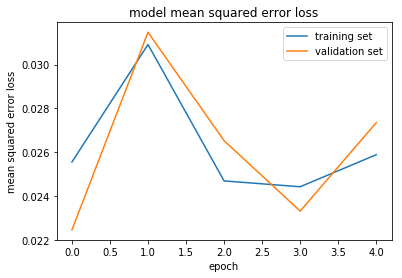

In [7]:
import matplotlib.pyplot as plt

### print the keys contained in the history object
def plotHistory(history):
    print(history.keys())
    for key in history.keys():
        print ("key:", key,", values:", history_object.history[key])

    ### plot the training and validation loss for each epoch
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()
    
plotHistory(history_object.history)

### fit model to center driving image set created from short section just past bridge
#### plot loss history
#### save model

lines: 2125
train_samples: 1700 validation_samples: 425
train_samples[0]: 7
Epoch 1/5
1536/1700 [==========================>...] - ETA: 0s - loss: 0.0423

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


1728/1700 [==============================] - 9s - loss: 0.0446 - val_loss: 0.0316
Epoch 2/5
1728/1700 [==============================] - 9s - loss: 0.0306 - val_loss: 0.0326
Epoch 3/5
1728/1700 [==============================] - 9s - loss: 0.0316 - val_loss: 0.0358
Epoch 4/5
1728/1700 [==============================] - 9s - loss: 0.0263 - val_loss: 0.0264
Epoch 5/5
1728/1700 [==============================] - 9s - loss: 0.0359 - val_loss: 0.0340
dict_keys(['loss', 'val_loss'])
key: loss , values: [0.044619246903393001, 0.030613564161790743, 0.031649237084719867, 0.026303116646077897, 0.035884663669599429]
key: val_loss , values: [0.031647508343060814, 0.032598581165075302, 0.035764757543802261, 0.026425447314977646, 0.034001981916084681]


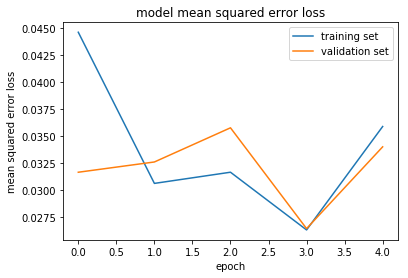

saving model as: 2017_07_17_18_43.model


In [8]:
DATADIRECTORY="./simData"
IMAGEDIRECTORY="./simData/dirtroad/IMG"
DRIVINGLOG=DATADIRECTORY+"/dirtroad/driving_log.csv"
lines=[]
with open(DRIVINGLOG) as csvFile:
    reader=csv.reader(csvFile)
    for line in reader:
        lines.append(line)
print("lines:", len(lines))

train_samples, validation_samples = train_test_split(lines, test_size=0.2)
print("train_samples:", len(train_samples), "validation_samples:", len(validation_samples))
print("train_samples[0]:",len(train_samples[0]))

# compile and train the model using the generator function
train_generator = generator(train_samples, batchSize=BATCHSIZE)
validation_generator = generator(validation_samples, batchSize=BATCHSIZE)

stopOnValLossOf_018 = EarlyStoppingByLossVal(value=0.018, verbose=1)
adamOptimizer.lr.value=0.0001
history_object=model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator,
                                   nb_val_samples=len(validation_samples), nb_epoch=5, callbacks=[stopOnValLossOf_018])

#history_object=model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator,
#                                  nb_val_samples=len(validation_samples), nb_epoch=10)

plotHistory(history_object.history)

import datetime

modelFilename=datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")+".model"
print ("saving model as:", modelFilename)
model.save(modelFilename)